什么是 Top-K 和 Top-P 采样？Temperature 如何影响生成结果？

In [ ]:
import numpy as np

# 概率分布          0    1   2     3     4
probs = np.array([0.4, 0.3, 0.2, 0.05, 0.05])
words = ['A', 'B', 'C', 'D', '<eos>']

# 设置 Top-K
K = 3

# 获取概率最高的 K 个词汇索引
top_indices = np.argsort(probs)[-K:]
top_k_probs = np.zeros_like(probs)
top_k_probs[top_indices] = probs[top_indices]
# 归一化
top_k_probs /= np.sum(top_k_probs)

# 打印 Top-K 词汇及其概率
for i in range(K):
    print(f"Word：{words[top_indices[i]]} Probability: {top_k_probs[top_indices[i]]:.2f}")

Word：C Probability: 0.22
Word：B Probability: 0.33
Word：A Probability: 0.44


In [ ]:
import numpy as np

# 概率分布
probs = np.array([0.4, 0.3, 0.2, 0.05, 0.05])
words = ['A', 'B', 'C', 'D', '<eos>']   

# 设置 Top-P
P = 0.6

# 对概率进行排序
sorted_indices = np.argsort(probs)[::-1]  # 从大到小排序
sorted_probs = probs[sorted_indices]
print(sorted_probs)
# 累计概率
cumulative_probs = np.cumsum(sorted_probs)
print(cumulative_probs)
# 找到 一开始大于等于P的概率。 
index = np.where(cumulative_probs >= P)[0][0]
print(index)
# 保留累积概率达到 P 的词汇及其概率
top_p_probs = np.zeros_like(probs)
top_p_probs[sorted_indices[:index+1]] = sorted_probs[:index+1]
# 归一化保留的词汇的概率
top_p_probs = top_p_probs / np.sum(top_p_probs)
# 打印 Top-P 采样的结果
print("\nTop-P 采样选择的词汇和对应的概率：")
for i in np.where(top_p_probs > 0)[0]:
    print(f"{words[i]}: {top_p_probs[i]:.2f}")

[0.4  0.3  0.2  0.05 0.05]
[0.4  0.7  0.9  0.95 1.  ]
1

Top-P 采样选择的词汇和对应的概率：
A: 0.57
B: 0.43



--- Temperature = 0.5 ---
A: 0.54
B: 0.31
C: 0.14
D: 0.01
<eos>: 0.01

--- Temperature = 1.0 ---
A: 0.40
B: 0.30
C: 0.20
D: 0.05
<eos>: 0.05

--- Temperature = 1.5 ---
A: 0.34
B: 0.28
C: 0.21
D: 0.08
<eos>: 0.08


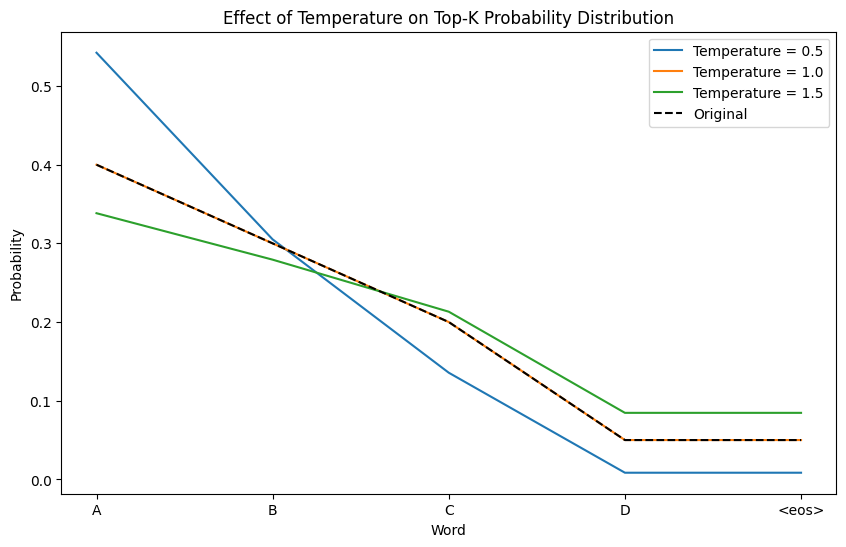

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# 概率分布
probs = np.array([0.4, 0.3, 0.2, 0.05, 0.05])
words = ['A', 'B', 'C', 'D', '<eos>']

# 设置 Top-K
K = 5

# 设置不同的 Temperature 值
temperatures = [0.5, 1.0, 1.5]

# 创建一个图表
plt.figure(figsize=(10, 6))

# 遍历不同的温度
for temp in temperatures:
    # 使用 Temperature 调整概率
    adjusted_probs = probs ** (1.0 / temp)
    adjusted_probs = adjusted_probs / np.sum(adjusted_probs)  # 归一化
    
    # 打印当前 Temperature 的概率分布
    print(f"\n--- Temperature = {temp} ---")
    for i, prob in enumerate(adjusted_probs):
        print(f"{words[i]}: {prob:.2f}")
    
    # 绘制概率分布图
    plt.plot(words, adjusted_probs, label=f"Temperature = {temp}")

# 绘制原始概率分布的对比
plt.plot(words, probs, label="Original", linestyle="--", color="black")

# 添加图表信息
plt.xlabel("Word")
plt.ylabel("Probability")
plt.title("Effect of Temperature on Top-K Probability Distribution")
plt.legend()

# 显示图表
plt.show()

In [33]:
import warnings
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# 忽略 FutureWarning 警告
warnings.filterwarnings("ignore", category=FutureWarning)

# 指定模型
model_name = "distilgpt2"

# 加载分词器和模型
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# 将模型移动到设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 输入文本
input_text = "Hello GPT"

# 编码输入文本
inputs = tokenizer.encode(input_text, return_tensors="pt").to(device)
attention_mask = torch.ones_like(inputs).to(device)

# 设置 Top-K 和 Top-P 采样
top_k = 10
top_p = 0.5
temperature = 0.8

# 生成文本，结合 Top-K 和 Top-P 采样
with torch.no_grad():
    outputs = model.generate(
        inputs,
        attention_mask=attention_mask,
        max_length=50,
        do_sample=True,
        top_k=top_k,                # 设置 Top-K
        top_p=top_p,                # 设置 Top-P
        temperature=temperature,    # 控制生成的随机性
        no_repeat_ngram_size=2,     # 防止重复 n-gram
        pad_token_id=tokenizer.eos_token_id
    )

# 解码生成的文本
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("结合 Top-K 和 Top-P 采样生成的文本: ")
print(generated_text)

2025-08-18 22:17:54.549516: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-18 22:17:54.565915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755526674.576808   30834 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755526674.580565   30834 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755526674.599276   30834 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

结合 Top-K 和 Top-P 采样生成的文本: 
Hello GPT.

The first of the three new features of GPP is the ability to create a new GPS file. The new feature is that you can create an image with a GPGP file, or you could create it with
